# Sea ice seasonality (SIS) trends
Comparison between ACCESS-OM2-01 outputs and the [NASA Goddard](https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-nasa-goddard-and-nsidc-based-nasa-team-algorithm) observations obtained via passive microwaves.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [4]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# import netCDF4 as nc
import ZonalStatsFunctions as zsf
import xarray as xr
import numpy as np
import pandas as pd
import os
from dask.distributed import Client
from glob import glob
import xesmf as xe
import geopandas

#Useful for plotting figures, including maps
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft

## Parallelising work
Start a cluster that uses multiple cores to parallelise work. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [2]:
client = Client(n_workers = 8)

## Loading sea ice concentration observations

In [11]:
#Observational data file path to main folder location
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'

#Get a list of all files inside the year folders
obsSHFileList = sorted(glob(os.path.join(ObsDir, 'south/daily/*/*'), recursive = True))

#Create a list of the years of interest.
years = np.arange(1978, 2020)

# Load all files that are within the years of interest
for year in years:
    #Create an empty list to hold all filepaths
    fileList = []
    for file in obsSHFileList:
        if file[-18:-14] == str(year):
            #Only one variable 'goddard_merged_seaice_conc' is loaded as it is the only one of interest
            dataarray = xr.open_dataset(file, decode_times = False, autoclose = True)['goddard_merged_seaice_conc']
            fileList.append(dataarray)
    #Create a new data array with all time steps
    fileList = xr.concat(fileList, dim = 'time', coords = 'minimal')    
    if 'time' in fileList.coords:
        #Apply the same time units given in time dimension to time coordinates
        time_units = fileList.time.units
        #Decode date time data to CF conventions
        decoded_time = xr.conventions.times.decode_cf_datetime(fileList.time, time_units)
        fileList.coords['time'] = ('time', decoded_time,
                                   {'long_name': 'time', 'decoded_using': time_units})
    # replace values outside valid range (0-1) with nan
    fileList = fileList.where(xr.ufuncs.logical_and(fileList >=0, fileList <= 1), np.nan)
    
    #Save data array
    fileList.to_netcdf(f'/g/data/v45/la6889/Observations/sea_ice_conc_obs_{str(year)}.nc')

## Correcting missing dates in sea ice concentration observations
There are two ways of missing dates were corrected, following [Masson et al 2013](https://doi.org/10.1371/journal.pone.0064756):
- Between January 1979 and November 1987, days of missing data were interpolated from adjoining days
- Between December 1987 and January 1988, missing days were replaced with daily climatology (1979-2009)

### Loading original data from Jan 1979 to Nov 1987 and create a new data array

In [3]:
#Observational data file path to main folder location
ObsDir = '/g/data/v45/la6889/Observations'

#For the period between Feb 1979 and Feb 1987, data was interpolated
years = np.arange(1978, 1988)

#Get a list of all files inside the year folders
obs_files = sorted(glob(os.path.join(ObsDir, '*.nc')))
#Empty list to store file list of years when correction will be applied
obslist = []
#Looping through file list
for yr in years:
    [obslist.append(xr.open_dataarray(file)) for file in obs_files if str(yr) in file]

#Creating a multi dimensional array
obs = xr.concat(obslist, dim = 'time').sortby('time')

### Interpolating data for period between Jan 1979 and Nov 1987

In [4]:
#Get list of dates not included in observational data
obs_time = obs.time.values
complete_time = pd.date_range(obs.time.values.min(), obs.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))
#Create an empty list to hold interpolated days
int_data = []

#Interpolate only days that are missing
for md in miss_days:
    #Select the day prior and the day after missing date
    int_range = obs.sel(time = slice(md-np.timedelta64(1, 'D'), md+np.timedelta64(1, 'D')))
    #Perform interpolation
    int_range = int_range.interp(time = pd.date_range(md - np.timedelta64(1, 'D'), md + np.timedelta64(1, 'D')))
    #Save interpolated missing date in a list
    int_data.append(int_range.sel(time = md))

#Create a new array with missing dates
obs_corr = xr.concat([obs, xr.concat(int_data, dim = 'time')], dim = 'time').sortby('time')

#Remove variables no longer in use
del obs, years, obslist, obs_time, complete_time, miss_days

### Loading original data from 1988 to 2009

In [5]:
#Defining years
years = np.arange(1988, 2010)

#Create empty list to hold file list
obslist = []

#Load data arrays
for yr in years:
    [obslist.append(xr.open_dataarray(file)) for file in obs_files if str(yr) in file]

#Create a new data array to calculate climatology. Joining original files just loaded and the interpolated data
obs_clim = xr.concat([obs_corr.sel(time = slice('1979-01-01', obs_corr.time.values.max())),
                      xr.concat(obslist, dim = 'time')], dim = 'time')

### Checking there are no other missing days outside the period between Dec 1987 and Jan 1988

In [6]:
#Get list of dates not included in observational data
obs_time = obs_clim.time.values
complete_time = pd.date_range(obs_clim.time.values.min(), obs_clim.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))

#Checking that there are no missing dates outside 1987-1988
yrs = []
[yrs.append(pd.Timestamp(md).timetuple().tm_year) for md in miss_days]
#Compare years
dif = list(set(yrs) ^ set([1987, 1988]))

int_data = []
#Get list of missing data outside 1987-1988
for d in dif:
    for md in miss_days:
        if str(d) in str(pd.to_datetime(md)):
            #Select the day prior and the day after missing date
            int_range = obs_clim.sel(time = slice(md-np.timedelta64(1, 'D'), md+np.timedelta64(1, 'D')))
            #Perform interpolation
            int_range = int_range.interp(time = pd.date_range(md - np.timedelta64(1, 'D'), md + np.timedelta64(1, 'D')))
            #Save interpolated missing date in a list
            int_data.append(int_range.sel(time = md))

#Add interpolated day prior to calculating daily climatology
obs_clim = xr.concat([obs_clim, xr.concat(int_data, dim = 'time')], dim = 'time').sortby('time')

#Calculate climatology
daily_clim = obs_clim.groupby('time.dayofyear').mean('time')

### Replacing missing days between Dec 1987 and Jan 1988 with climatology (1979-2009)

In [12]:
#Get list of dates not included in observational data
obs_time = obs_clim.time.values
complete_time = pd.date_range(obs_clim.time.values.min(), obs_clim.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))

#Replace missing dates with climatology
corr_dates = []
for md in miss_days:
    #Add a day to dates in 1987 because daily climatology includes leap day
    if '1987' in str(pd.to_datetime(md)):
        ind = pd.Timestamp(md).timetuple().tm_yday+1
    else:
        ind = pd.Timestamp(md).timetuple().tm_yday
    corr_dates.append(daily_clim.sel(dayofyear = ind).drop('dayofyear').expand_dims({'time': [md]}))

#Save everything in corrected data array
obs_clim = xr.concat([obs_clim, xr.concat(corr_dates, dim = 'time')], dim = 'time').sortby('time')

### Saving corrected data

In [30]:
out_file = r'/g/data/v45/la6889/Observations/'
years = [*np.arange(1979, 1989), *dif]

for yr in years:
    obs_clim.sel(time = str(yr)).to_netcdf(os.path.join(out_file, f'sea_ice_conc_obs_{yr}.nc'))

## Defining function to calculate sea ice seasonality

In [61]:
def SeaIceAdvArrays(array, dir_out, thres = 0.15, ndays = 5):
    '''
    Inputs:
    array is the data array on which sea ice seasonality calculations will be performed
    dir_out is the file path to the folder where outputs should be saved.
    thres refers to the minimum sea ice concentration threshold. The default is set to 0.15
    ndays is the minimum amount of consecutive days sea ice must be above threshold to be classified as advancing. Default set to 5
    
    Outputs:
    Function saves three data arrays as netcdf files: advance, retreat and season duration. Data arrays can also be saved as variables in the notebook.
    '''
    
    #Extracting maximum and minimum year information to extract data for the sea ice year 
    MinY = str(array.time.dt.year.values.min())
    MaxY = str(array.time.dt.year.values.max())
    
    #Selecting data between Feb 15 to Feb 14 (sea ice year)
    array = array.sel(time = slice(f'{MinY}-02-15', f'{MaxY}-02-14'))
    
    ########
    #Preparing masks to perform calculations on areas of interest only
    #Calculate timesteps in dataset (365 or 366 depending on whether it was a leap year or not)
    timesteps = len(array.time.values)

    #Identify pixels (or cells) where sea ice concentration values are equal or above the threshold
    #Resulting data array is boolean. If condition is met then pixel is set to True, otherwise set to False
    threshold = xr.where(array >= thres, True, False)

    #Creating masks based on time over threshold
    #Add values through time to get total of days with ice cover of at least 15% within a pixel
    rsum = threshold.sum('time')

    #Boolean data arrays for masking
    #If the total sum is zero, then set pixel to be True, otherwise set to False. 
    #This identifies pixels where minimum sea ice concentration was never reached.
    noIce = xr.where(rsum == 0, True, False)
    #If the total sum is less than the minimum days, then set pixel to be True, otherwise set to False. 
    #This identifies pixels where sea ice coverage did not meet the minimum consecutive days requirement.
    noIceAdv = xr.where(rsum < ndays, True, False)
    #If the total sum is the same as the timesteps, then set pixel to be True, otherwise set to False.
    #This identifies pixels where sea ice concentration was always at least 15%
    alwaysIce = xr.where(rsum == timesteps, True, False)
    #Remove unused variables
    del rsum

    ########
    #Sea ice advance calculations
    #Use cumulative sums based on time. If pixel has sea ice cover below threshold, then cumulative sum is reset to zero
    adv = threshold.cumsum(dim = 'time')-threshold.cumsum(dim = 'time').where(threshold == 0).ffill(dim = 'time').fillna(0)
    #Note: ffill adds nan values forward over a specific dimension

    #Find timestep (date) where the minimum consecutive sea ice concentration was first detected for each pixel
    #Change all pixels that do not meet the minimum consecutive sea ice concentration to False. Otherwise maintain their value.
    advDate = xr.where(adv == ndays, adv, False)
    #Find the time step index where condition above was met.
    advDate = advDate.argmax(dim = 'time')
    #Apply masks of no sea ice advance and sea ice always present.
    advDate = advDate.where(noIceAdv == False, np.nan).where(alwaysIce == False, 1)
    #Remove unused variables
    del adv

    ########
    #Sea ice retreat calculations
    #Reverse threshold data array (time wise) - So end date is now the start date and calculate cumulative sum over time
    ret = threshold[::-1].cumsum('time')
    del threshold
    #Change zero values to 9999 so they are ignored in the next step of our calculation
    ret = xr.where(ret == 0, 9999, ret)
    #Find the time step index where sea ice concentration change to above threshold.
    retDate = ret.argmin(dim = 'time')
    #Substract index from total time length
    retDate = timesteps-retDate
    #Apply masks of no sea ice over threshold and sea ice always over threshold.
    retDate = retDate.where(noIce == False, np.nan).where(alwaysIce == False, timesteps)
    #Remove unused variables
    del ret
    
    ########
    #Sea ice duration
    durDays = retDate-advDate
    #Remove unused variables
    del noIce, noIceAdv, alwaysIce
    
    ########
    #Adding a time dimension to newly created arrays and removing unused dimensions
    def addTime(array, year):
        #Create a time variable to add as dimension to each array - Only one timestep included
        time = pd.date_range(f'{year}-02-15', f'{year}-02-16', freq = 'D', closed = 'left')
        #Add time dimension to data array
        x = array.expand_dims({'time': time}).assign_coords({'time': time})
        #Return 
        return x
         
    #Applying function
    advDate2 = addTime(advDate, MinY)
    retDate2 = addTime(retDate, MinY)
    durDate = addTime(durDays, MinY)
    del advDate, retDate, durDays
    
    os.makedirs(dir_out, exist_ok = True)
    
    ########
    #Save corrected outputs as netcdfiles
    #Define output paths
    advpath = os.path.join(dir_out, (f'SeaIceAdv_{MinY}-{MaxY}.nc'))
    retpath = os.path.join(dir_out, (f'SeaIceRet_{MinY}-{MaxY}.nc'))
    durpath = os.path.join(dir_out, (f'SeaIceDur_{MinY}-{MaxY}.nc'))
    
    #Save files simultaneously
    xr.save_mfdataset(datasets = [advDate2.to_dataset(), retDate2.to_dataset(), durDate.to_dataset()], paths = [advpath, retpath, durpath])
    
    #Return data arrays as outputs
    return (advDate2, retDate2, durDate)

## Defining function to stack various netcdf files in one data array

In [4]:
def combineData(filepath, filelist, dir_out):
    '''
    Inputs:
    filepath - refers to the file path of the folder containing the netcdf files to be combined into a single data array.
    filelist - contains the actual names of the netcdf files that will be combined..
    dir_out - file path of the folder where combined data arrays will be saved
      
    Outputs:
    Three dimensional data array containing all files provided in the filelist input. The data array is saved to the path provided in dir_out and it can also be assigned to a variable.
    '''
    #Create variable to hold combined data arrays
    combData = []
    #Create loop based on the total length of filelist
    for i in np.arange(0, len(filelist)):
        #Open data array
        x = xr.open_dataarray(os.path.join(filepath, filelist[i]), autoclose = True)
        #Put all files in one variable
        combData.append(x)
        
    #Create one data array with the data contained in the combined variable
    combined = xr.concat(combData, dim = 'time')
    os.makedirs(dir_out, exist_ok = True)
    combined.to_netcdf(os.path.join(dir_out, (filelist[0][0:15]+filelist[-1][15:19]+'.nc')))
    return combined

## Applying sea ice seasonality function

In [62]:
#Location of observation files
in_file = '/g/data/v45/la6889/Observations/*.nc'
fileList = sorted(glob(in_file))

#Years of interest
s_yr = np.arange(1979, 2018)
e_yr = np.arange(1990, 2019)

#Location where output files will be saved
dir_out = r'/g/data/v45/la6889/Observations/SIS'

for start, end in zip(s_yr, e_yr):
    files = []
    iceObs = []
    [files.append(f) for f in fileList if str(start) in f or str(end) in f]
    for file in files:
        iceObs.append(xr.open_dataarray(os.path.join(in_file, file)))
    iceObs = xr.concat(iceObs, dim = 'time')
    SeaIceAdvArrays(iceObs, dir_out = dir_out)

## Loading SIS results

In [7]:
#File path of folder containing netcdf files
filein = r'/g/data/v45/la6889/Observations/SIS'
dir_out = r'/g/data/v45/la6889/Observations/SIS/Climatology'

#Define years of interest
yrs = np.arange(1989, 2018)

#Apply the getFileList function to create maps for all years of interest
adv_list, ret_list, dur_list = zsf.getFileList(filein, yrs)

obs = {}
obs['advance'] = zsf.combineData(adv_list)#, dir_out = dir_out)
obs['retreat'] = zsf.combineData(ret_list)#, dir_out = dir_out)
obs['duration'] = zsf.combineData(dur_list)#, dir_out = dir_out)

seasons = sorted([s for s in obs.keys()])

## Calculating linear trends in sea ice seasons

In [6]:
dir_out = r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Observations/'

seasons = ['advance', 'retreat', 'duration']

for season in seasons:
    #Extracting years to calculate linear trends
    yrs = obs[season].time.dt.year.values
    #Extract values from SI seasonality data and create a vector
    vals = obs[season].values.reshape(len(yrs), -1)
    
    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = yrs)
    
    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = obs[season].xgrid.values, 
                                        ygrid = obs[season].ygrid.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = obs[season].xgrid.values, 
                                        ygrid = obs[season].ygrid.values),
                          name = "p_values")
    
    LM_results = xr.merge([coef_r, pval_r]).expand_dims({'season': [season]})
    
    #Ensure directory exists prior to saving results
    os.makedirs(dir_out, exist_ok = True)
    
    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, 
                                      (f'LinearTrend_SeaIce_{season}_{str(yrs.min())}-{str(yrs.max())}.nc')))

### Load sea ice seasonality trends

In [8]:
fileList = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Observations/*.nc'))
seasons = ['advance', 'retreat', 'duration']
SI_LTrends = {}

for f, s in zip(fileList, seasons):
    SI_LTrends[s] = xr.open_dataset(f)

## Plot linear trends from observations in sea ice seasonality

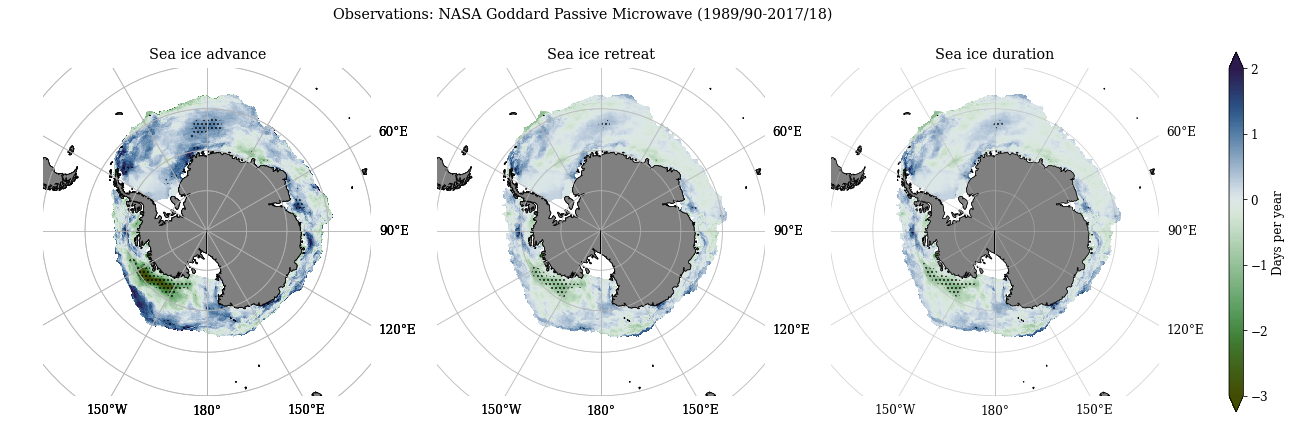

In [8]:
#Set color palette for trends to be centered at zero
divnorm = mcolors.TwoSlopeNorm(vmin = -3, vcenter = 0, vmax = 2)

#Creating color maps to be used in both plot types
roma, roma_r = zsf.colourMaps('../../ScientificColourMaps6/', 'cork', rev = True)

#Initialise figure
fig = plt.figure(figsize = (20, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 1, ncols = len(seasons))
#Change the width between each plot
gs.update(wspace = 0.2)

#Set up variable to contain axes
axs = {}

########
#Plot linear trends in sea ice seasons
for i in range(0, len(seasons)):
    #Add subplots with linear trends 
    axs[seasons[i] + 'trend'] = fig.add_subplot(gs[i], projection = projection)

    #Add contour plot of sea ice advance
    p = SI_LTrends[seasons[i]].coefficients[0].plot.\
    pcolormesh(x = 'xgrid', y = 'ygrid', ax = axs[seasons[i] + 'trend'],
               #Setting color palette and contour levels
               cmap = roma_r, transform = ccrs.SouthPolarStereo(), 
               add_colorbar = False, norm = divnorm)

    #Add subplots with statistical significance
    sig = xr.where(SI_LTrends[seasons[i]].p_values[0] <= 0.05, True, np.nan)
    sig.plot.contourf(hatches = ['...'], colors = 'none', ax = axs[seasons[i] + 'trend'], 
                      transform = ccrs.SouthPolarStereo(), add_colorbar = False)
   
    #Add subplot title
    axs[seasons[i] + 'trend'].set_title(f'Sea ice {seasons[i]}', y = 1.01)
    
   
     ######
    #Set colourbars as an inset to last row only
    if i == (len(seasons)-1):
        #Linear trends - width and height of the colourbar 
        cb_lt = inset_axes(axs[seasons[i] + 'trend'], width = 0.2, height = 5, loc = 'right', 
                           #defining where the colourbar will appear (left, bottom, width, height)
                           bbox_to_anchor = (0.275, 0, 1, 1), 
                           bbox_transform = axs[seasons[i] + 'trend'].transAxes)
        #Apply colourbar to figure and set it to be horizontal
        fig.colorbar(p, cax = cb_lt, label = 'Days per year', extend = 'both')
        
    ######
    for ax in axs.values():
        #Remove x and y axes labels
        ax.set_ylabel("")
        ax.set_xlabel("")
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.ylabels_left = False
        gl.ylabels_right = True
        gl.xlabels_top = False
        gl.ylabels_top = False
        gl.xlabels_bottom = True
        gl.ylabels_bottom = False
        #Remove outside border
        [s.set_visible(False) for s in ax.spines.values()]

fig.suptitle('Observations: NASA Goddard Passive Microwave (1989/90-2017/18)', y = 0.92)

# Ensure output folder exists
out_file = r'/g/data/v45/la6889/Observations/SIS/Figures/Maps/LinearTrends'
os.makedirs(out_file, exist_ok = True)
# Saving final figure
plt.savefig(os.path.join(out_file, 'SeaIceSeasons_LinearTrends_1989-2018.png'), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## ACCESS-OM2-01 outputs

### Loading sea ice seasonality calculations

In [9]:
#Defining sea ice seasons
SI_seasons = ['advance', 'duration', 'retreat']

fileList = sorted(glob(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/*.nc'))
SI_data = {}

for f, s in zip(fileList, SI_seasons):
    SI_data[s] = xr.open_dataarray(f).sel(time = slice('1989', '2019'))

### Calculating linear trends from ACCESS-OM2 data 

In [11]:
dir_out = r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Model'

for season in SI_seasons:
    #Extracting years to calculate linear trends
    yrs = SI_data[season].time.dt.year.values
    #Extract values from SI seasonality data and create a vector
    vals = SI_data[season].values.reshape(len(yrs), -1)
    
    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = yrs)
    
    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(SI_data[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = SI_data[season].xt_ocean.values, 
                                        yt_ocean = SI_data[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(SI_data[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = SI_data[season].xt_ocean.values, 
                                        yt_ocean = SI_data[season].yt_ocean.values),
                          name = "p_values")
    
    LM_results = xr.merge([coef_r, pval_r]).expand_dims({'season': [season]})
    
    #Ensure directory exists prior to saving results
    os.makedirs(dir_out, exist_ok = True)
    
    #Saving outputs
    LM_results.to_netcdf(os.path.join(dir_out, 
                                      (f'LinearTrend_Model_SeaIce_{season}_{str(yrs.min())}-{str(yrs.max())}.nc')))

### Loading sea ice seasonality linear trends to avoid calculating again

In [10]:
#Location of linear trends
fileList = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Model/*Model*.nc'))

#Sea ice seasons
SI_seasons = ['advance', 'duration', 'retreat']

#Empty dictionary to save linear trends (model outputs)
SI_mod_LTrends = {}

for f, s in zip(fileList, SI_seasons):
    SI_mod_LTrends[s] = xr.open_dataset(f)

### Plot SIS linear trends

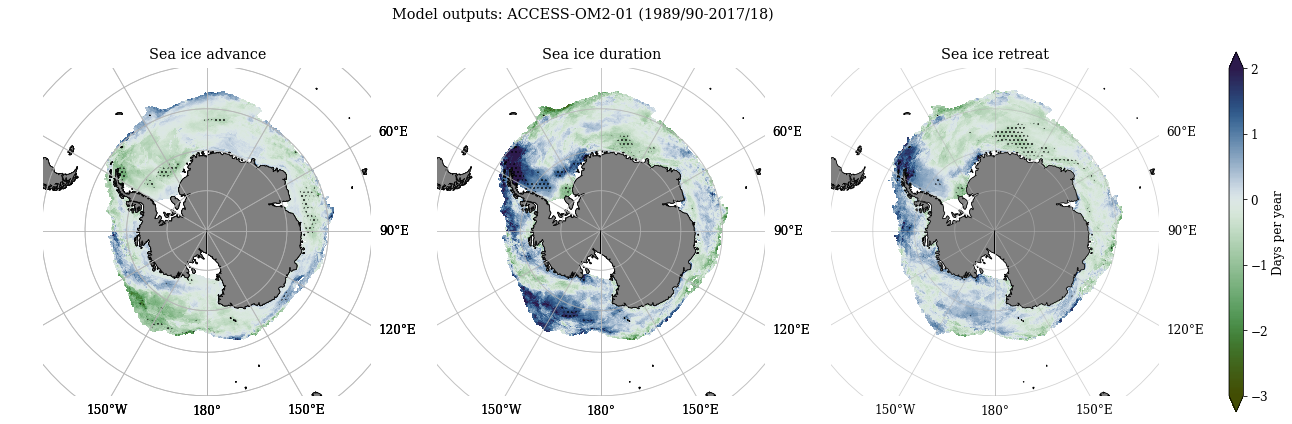

In [16]:
#Set color palette for trends to be centered at zero
divnorm = mcolors.TwoSlopeNorm(vmin = -3, vcenter = 0, vmax = 2)

#Creating color maps to be used in both plot types
roma, roma_r = zsf.colourMaps('../../ScientificColourMaps6/', 'cork', rev = True)

#Initialise figure
fig = plt.figure(figsize = (20, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 1, ncols = len(SI_seasons))
#Change the width between each plot
gs.update(wspace = 0.2)

#Set up variable to contain axes
axs = {}

########
#Plot linear trends in sea ice seasons
for i in range(0, len(SI_seasons)):
    #Add subplots with linear trends 
    axs[SI_seasons[i] + 'trend'] = fig.add_subplot(gs[i], projection = projection)

    #Add contour plot of sea ice advance
    p = SI_mod_LTrends[SI_seasons[i]].coefficients[0].plot.\
    pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axs[SI_seasons[i] + 'trend'],
               #Setting color palette and contour levels
               cmap = roma_r, transform = ccrs.PlateCarree(), 
               add_colorbar = False, norm = divnorm)

    #Add subplots with statistical significance
    sig = xr.where(SI_mod_LTrends[SI_seasons[i]].p_values[0] <= 0.05, True, np.nan)
    sig.plot.contourf(hatches = ['...'], colors = 'none', ax = axs[SI_seasons[i] + 'trend'], 
                      transform = ccrs.PlateCarree(), add_colorbar = False)
    
    #Add subplot title
    axs[SI_seasons[i] + 'trend'].set_title(f'Sea ice {SI_seasons[i]}', y = 1.01)
    
   
     ######
    #Set colourbars as an inset to last row only
    if i == (len(SI_seasons)-1):
        #Linear trends - width and height of the colourbar 
        cb_lt = inset_axes(axs[SI_seasons[i] + 'trend'], width = 0.2, height = 5, loc = 'right', 
                           #defining where the colourbar will appear (left, bottom, width, height)
                           bbox_to_anchor = (0.275, 0, 1, 1), 
                           bbox_transform = axs[SI_seasons[i] + 'trend'].transAxes)
        #Apply colourbar to figure and set it to be horizontal
        fig.colorbar(p, cax = cb_lt, label = 'Days per year', extend = 'both')

    ######
    for ax in axs.values():
        #Remove x and y axes labels
        ax.set_ylabel("")
        ax.set_xlabel("")
        #Coastlines to appear
        ax.coastlines(resolution = '50m')
        #Add feature loaded at the beginning of this section
        ax.add_feature(land_50m)
        #Set the extent of maps
        ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
        #Adding gridlines gridlines - Removing any labels inside the map on the y axis
        gl = ax.gridlines(draw_labels = True, y_inline = False, color = "#b4b4b4", alpha = 0.6)
        #Locate longitude ticks - Set to every 30 deg
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
        #Set rotation of longitude labels to zero
        gl.xlabel_style = {'rotation': 0}
        #Set latitude labels to be transparent
        gl.ylabel_style = {'alpha': 0}
        #Add space between axis ticks and labels for x and y axes
        gl.xpadding = 8
        gl.ypadding = 8
        gl.ylabels_left = False
        gl.ylabels_right = True
        gl.xlabels_top = False
        gl.ylabels_top = False
        gl.xlabels_bottom = True
        gl.ylabels_bottom = False
        #Remove outside border
        [s.set_visible(False) for s in ax.spines.values()]

fig.suptitle('Model outputs: ACCESS-OM2-01 (1989/90-2017/18)', y = 0.92)
        
# Ensure output folder exists
out_file = r'/g/data/v45/la6889/Observations/SIS/Figures/Maps/LinearTrends'
os.makedirs(out_file, exist_ok = True)
# Saving final figure
plt.savefig(os.path.join(out_file, 'SeaIceSeasons_Model_LinearTrends_1989-2018.png'), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Comparison of linear trends in SIS calculated from model outputs and observations 

### Matching CRS for observations and model outputs
For information about data projection, refer to this [page](https://nsidc.org/data/polar-stereo/ps_grids.html). This version of the data uses WGS 84 / NSIDC Sea Ice Polar Stereographic South projection [(EPSG: 3976)](http://epsg.io/3976).

In [11]:
#Location of linear trend (observation) files
fileList = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Observations/*.nc'))

#Location where reprojected files will be saved
file_out = r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Observations/Transformed_wgs84/'
os.makedirs(file_out, exist_ok = True)

#Seasons
SI_seasons = ['advance', 'duration', 'retreat']

#Empty list that will contain reprojected files
reproj_obs = {}

#Applying reprojection to all linear trend files
for f, s in zip(fileList, SI_seasons):
    #Open file, but only keep coefficient information. Rename dimensions containing coordinate data
    coef = xr.open_dataset(f).coefficients[0].drop('season').rename({'xgrid': 'x', 
                                                                     'ygrid': 'y'})
    #Applying reprojection
    reproj_obs[s] = zsf.calculate_latlon_coords(coef, 'epsg:3976', 'epsg:4326')
    reproj_obs[s].to_netcdf(os.path.join(file_out, f'LinearTrend_SeaIce-{s}_wgs84_1989-2017.nc'))

### Calculating differences in linear trends between observations and model outputs

In [24]:
#Location of linear trends
file_obs = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Observations/Transformed_wgs84/*.nc'))
file_mod = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Model/*Model*.nc'))

#Defining seasons
SI_seasons = ['advance', 'duration', 'retreat']

#Dictionary that will contain results
LM_obs = {}
LM_obs_reproj = {}
LM_mod = {}

for fo, fm, s in zip(file_obs, file_mod, SI_seasons):
    #Load observations
    LM_obs[s] = xr.open_dataarray(fo)
    LM_obs_reproj[s] = zsf.reproject_latlon_coords(LM_obs[s], 'epsg:3976', 'epsg:4326')
    LM_mod[s] = xr.open_dataset(fm).coefficients[0].drop('season').\
    sel(yt_ocean = slice(-90, -50)).rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

In [27]:
#Output folder
file_out = r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Differences/'
file_highres = r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Observations/HighResolution/'
os.makedirs(file_out, exist_ok = True)
os.makedirs(file_highres, exist_ok = True)

#Dictionary that will contain results
LT_difs = {}

#Regridder only calculated once as the same will be applied for all seasons
reg_coarse = xe.Regridder(LM_mod[s], LM_obs_reproj[s], 'bilinear')

for s in SI_seasons:
    mod_c = reg_coarse(LM_mod[s])
    #Calculate differences in magnitude in trends
    LT_difs[f'MagDif_{s}'] = LM_obs[s] - mod_c
    LT_difs[f'MagDif_{s}'].to_netcdf(os.path.join(file_out, f'LinearTrend_MagDif_SeaIce_{s}_1989-2017.nc'))
    
    #Calculate differences in trend direction
    #Observations
    obs_dir = xr.where(LM_obs[s] > 0, 1, -1)
    obs_dir = xr.where(LM_obs[s] == 0, 0, obs_dir)
    obs_dir = xr.where(np.isnan(LM_obs[s]), np.nan, obs_dir)
    #Model outputs
    mod_dir = xr.where(mod_c > 0, 1, -1)
    mod_dir = xr.where(mod_c == 0, 0, mod_dir)
    mod_dir = xr.where(np.isnan(mod_c), np.nan, mod_dir)
    #Difference in direction
    LT_difs[f'DirDif_{s}'] = obs_dir-mod_dir
    LT_difs[f'DirDif_{s}'].to_netcdf(os.path.join(file_out, f'LinearTrend_DirDif_SeaIce_{s}_1989-2017.nc'))

In [ ]:

    #Improve resolutions of observations - Matching to model resolution
    # reg = xe.Regridder(obs, mod, 'bilinear')
    # obs_high = reg(obs)
    #Change any zero values north of 55S to NAs
    obs_high = xr.where((obs_high == 0) & (obs_high.lat > -55), np.nan, obs_high)
    obs_high.to_netcdf(os.path.join(file_highres, f'LinearTrend_SeaIce_{s}_1989-2017.nc'))
    
    #Calculate differences in magnitude in trends
    LT_difs[f'MagDif_{s}'] = obs_high - mod
    LT_difs[f'MagDif_{s}'].to_netcdf(os.path.join(file_out, f'LinearTrend_MagDif_SeaIce_{s}_1989-2017.nc'))
    
    #Calculate differences in trend direction
    #Observations
    obs_dir = xr.where(obs_high > 0, 1, -1)
    obs_dir = xr.where(obs_high == 0, 0, obs_dir)
    obs_dir = xr.where(np.isnan(obs_high), np.nan, obs_dir)
    #Model outputs
    mod_dir = xr.where(mod > 0, 1, -1)
    mod_dir = xr.where(mod == 0, 0, mod_dir)
    mod_dir = xr.where(np.isnan(mod), np.nan, mod_dir)
    #Difference in direction
    LT_difs[f'DirDif_{s}'] = obs_dir-mod_dir
    LT_difs[f'DirDif_{s}'].to_netcdf(os.path.join(file_out, f'LinearTrend_DirDif_SeaIce_{s}_1989-2017.nc'))

### Loading differences in linear trends (magnitude and direction) to avoid recalculation

In [13]:
#Location of linear trends
file_mag = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Differences/*MagDif*.nc'))
file_dif = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/LinearTrends/Differences/*DirDif*.nc'))

#Defining seasons
SI_seasons = ['advance', 'duration', 'retreat']

#Dictionary that will contain results
LT_difs = {}

for fm, fd, s in zip(file_mag, file_dif, SI_seasons):
    #Load observations
    LT_difs[f'DirDif_{s}'] = xr.open_dataarray(fd)
    LT_difs[f'MagDif_{s}'] = xr.open_dataarray(fm)

### Loading MEASO regions to overlay them on plot

<AxesSubplot:>

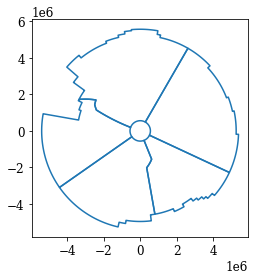

In [69]:
#Load shapefile
MEASO = geopandas.read_file('/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(np.unique(MEASO.sector)):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Checking results
MEASO_fixed.plot()

### Plotting differences in magnitude

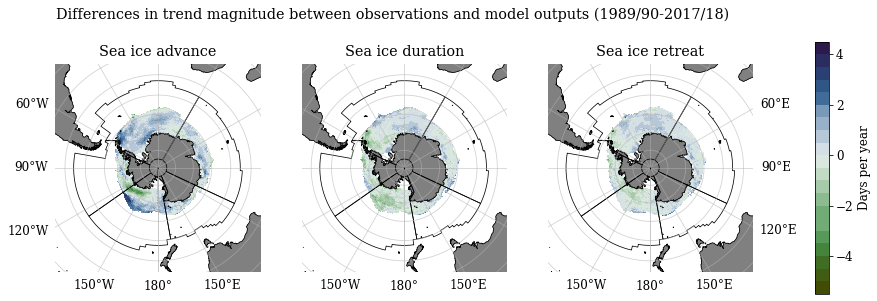

In [79]:
#Creating color maps to be used in both plot types
roma, roma_r = zsf.colourMaps('../../ScientificColourMaps6/', 'cork', rev = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 7.5))

levels = np.arange(-5.5, 4.6, 0.5)
divnorm = mcolors.TwoSlopeNorm(vmin = -5.5, vcenter = 0, vmax = 4.5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 1, ncols = len(SI_seasons))
#Change the width between each plot
gs.update(wspace = 0.2)

#Set up variable to contain axes
axs = {}

########
#Plot linear trends in sea ice seasons
for i, sea in enumerate(SI_seasons):
    #Add subplots with linear trends 
    axs[sea + 'trend'] = fig.add_subplot(gs[i], projection = projection)

    #Add contour plot of sea ice advance
    p = LT_difs[f'MagDif_{sea}'].plot.pcolormesh('lon', 'lat', 
                                                 ax = axs[sea + 'trend'],
                                                 #Setting color palette and contour levels
                                                 cmap = roma_r, norm = divnorm,
                                                 transform = ccrs.PlateCarree(),
                                                 levels = levels, add_colorbar = False)
    #Coastlines to appear
    axs[sea + 'trend'].coastlines(resolution = '50m')
    #Add feature loaded at the beginning of this section
    axs[sea + 'trend'].add_feature(land_50m)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = axs[sea + 'trend'])
    #Add subplot title
    axs[sea + 'trend'].set_title(f'Sea ice {sea}', y = 1.01)
    
    ######
    #Set colourbars as an inset to last row only
    if i == (len(SI_seasons)-1):
        #Linear trends - width and height of the colourbar 
        cb_lt = inset_axes(axs[sea + 'trend'], width = 0.2, height = 3.5, 
                           loc = 'right', 
                           #defining where the colourbar will appear (left, bottom, width, height)
                           bbox_to_anchor = (0.4, 0, 1, 1), 
                           bbox_transform = axs[sea + 'trend'].transAxes)
        #Apply colourbar to figure and set it to be horizontal
        fig.colorbar(p, cax = cb_lt, label = 'Days per year')

    ######
    # for ax in axs.values():
    #Remove x and y axes labels
    axs[sea + 'trend'].set_ylabel("")
    axs[sea + 'trend'].set_xlabel("")
    
    #Set the extent of maps
    axs[sea + 'trend'].set_extent([-180, 180, -80, -35], crs = ccrs.PlateCarree())
    #Adding gridlines gridlines - Removing any labels inside the map on the y axis
    gl = axs[sea + 'trend'].gridlines(draw_labels = True, y_inline = False, 
                                      color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 8
    gl.ypadding = 8
    gl.xlabels_top = False
    gl.ylabels_top = False
    if i == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 1:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.ylabels_right = False
        gl.ylabels_left = False
    else:
        gl.ylabels_left = False
        gl.xlabels_right = True
    #Remove outside border
    [s.set_visible(False) for s in axs[sea + 'trend'].spines.values()]

fig.suptitle('Differences in trend magnitude between observations and model outputs (1989/90-2017/18)', 
             y = 0.8)
        
# Ensure output folder exists
out_file = r'/g/data/v45/la6889/Observations/SIS/Figures/Maps/LinearTrends'
os.makedirs(out_file, exist_ok = True)
# Saving final figure
plt.savefig(os.path.join(out_file, 'SeaIceSeasons_MagDif_LinearTrends_1989-2018.png'), 
            dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

### Plotting differences in direction

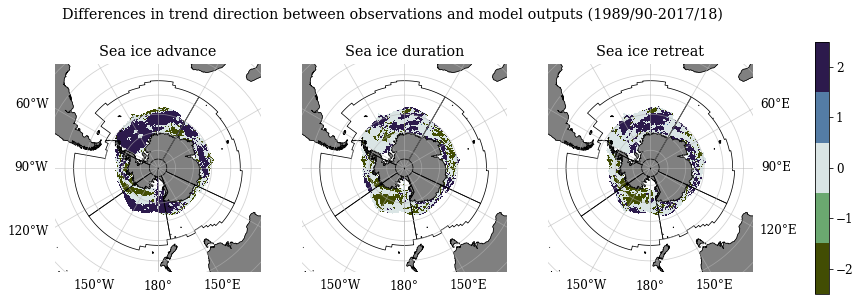

In [80]:
#Creating color maps to be used in both plot types
roma, roma_r = zsf.colourMaps('../../ScientificColourMaps6/', 'cork', rev = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 7.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 1, ncols = len(SI_seasons))
#Change the width between each plot
gs.update(wspace = 0.2)

#Set up variable to contain axes
axs = {}

########
#Plot linear trends in sea ice seasons
for i, sea in enumerate(SI_seasons):
    #Add subplots with linear trends 
    axs[sea + 'trend'] = fig.add_subplot(gs[i], projection = projection)
    cmap = plt.get_cmap(roma_r, 5)
    #Add contour plot of sea ice advance
    p = LT_difs[f'DirDif_{sea}'].plot.pcolormesh('lon', 'lat', 
                                                 ax = axs[sea + 'trend'],
                                                 #Setting color palette and contour levels
                                                 cmap = cmap, 
                                                 transform = ccrs.PlateCarree(),
                                                 levels = np.arange(-2.5, 2.6, 1),
                                                 vmin = -2.5, vmax = 2.5,
                                                 add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = axs[sea + 'trend'])
    #Add subplot title
    axs[sea + 'trend'].set_title(f'Sea ice {sea}', y = 1.01)
    
    ######
    #Set colourbars as an inset to last row only
    if i == (len(SI_seasons)-1):
        #Linear trends - width and height of the colourbar 
        cb_lt = inset_axes(axs[sea + 'trend'], width = 0.2, height = 3.5, loc = 'right', 
                           #defining where the colourbar will appear (left, bottom, width, height)
                           bbox_to_anchor = (0.4, 0, 1, 1), 
                           bbox_transform = axs[sea + 'trend'].transAxes)
        #Apply colourbar to figure and set it to be horizontal
        fig.colorbar(p, cax = cb_lt, label = '',
                    ticks = np.arange(-2, 2.1))

    ######

    #Remove x and y axes labels
    axs[sea + 'trend'].set_ylabel("")
    axs[sea + 'trend'].set_xlabel("")
    #Coastlines to appear
    axs[sea + 'trend'].coastlines(resolution = '50m')
    #Add feature loaded at the beginning of this section
    axs[sea + 'trend'].add_feature(land_50m)
    #Set the extent of maps
    axs[sea + 'trend'].set_extent([-180, 180, -80, -35], crs = ccrs.PlateCarree())
    #Adding gridlines gridlines - Removing any labels inside the map on the y axis
    gl = axs[sea + 'trend'].gridlines(draw_labels = True, y_inline = False, 
                                      color = "#b4b4b4", alpha = 0.6)
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Set rotation of longitude labels to zero
    gl.xlabel_style = {'rotation': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Add space between axis ticks and labels for x and y axes
    gl.xpadding = 8
    gl.ypadding = 8
    gl.xlabels_top = False
    gl.ylabels_top = False
    if i == 0:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.ylabels_right = False
    elif i == 1:
        gl.xlabels_left = False
        gl.xlabels_right = False
        gl.ylabels_right = False
        gl.ylabels_left = False
    else:
        gl.ylabels_left = False
        gl.xlabels_right = True
    #Remove outside border
    [s.set_visible(False) for s in axs[sea + 'trend'].spines.values()]

fig.suptitle('Differences in trend direction between observations and model outputs (1989/90-2017/18)', 
             y = 0.8)
        
# Ensure output folder exists
out_file = r'/g/data/v45/la6889/Observations/SIS/Figures/Maps/LinearTrends'
os.makedirs(out_file, exist_ok = True)
# Saving final figure
plt.savefig(os.path.join(out_file, 'SeaIceSeasons_DirDif_LinearTrends_1989-2018.png'), dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Comparing SIS metrics derived from observations and model outputs

### Matching CRS for observations and model outputs
For information about data projection, refer to this [page](https://nsidc.org/data/polar-stereo/ps_grids.html). This version of the data uses WGS 84 / NSIDC Sea Ice Polar Stereographic South projection [(EPSG: 3976)](http://epsg.io/3976).

In [131]:
#Location of linear trend (observation) files
filelist = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/*.nc'))

#Location where reprojected files will be saved
file_out = r'/g/data/v45/la6889/Observations/SIS/Transformed_SIS-Obs_wgs84/'
os.makedirs(file_out, exist_ok = True)

#Seasons
SI_seasons = ['advance', 'duration', 'retreat']

#Empty list that will contain reprojected files
reproj_obs = {}

#Applying reprojection to all linear trend files
for f in filelist:
    for s in SI_seasons:
        if s[:3] in f.lower():
            #Open file, but only keep coefficient information. Rename dimensions containing coordinate data
            SIS_obs = xr.open_dataarray(f).drop(('latitude', 'longitude')).rename({'xgrid': 'x', 'ygrid': 'y'})
            yr = SIS_obs.time.dt.year.values[0]
            #Applying reprojection
            reproj_obs[s] = zsf.calculate_latlon_coords(SIS_obs, 'epsg:3976', 'epsg:4326')
            reproj_obs[s].to_netcdf(os.path.join(file_out, f'SeaIce_{s}_wgs84_{str(yr)}-{str(yr+1)}.nc'))

### Regridding observations 

In [17]:
#Location of SIS files calculated from observations
file_obs = sorted(glob(r'/g/data/v45/la6889/Observations/SIS/Transformed_SIS-Obs_wgs84/*.nc'))

#Load model data for regridding
mod_da = xr.open_dataarray(r'/g/data/v45/la6889/Calculations/SeaIceSeasonality/Yearly/SeaIceAdv_1965-1966.nc')
mod_da = mod_da.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

#Output folder
file_out = r'/g/data/v45/la6889/Observations/SIS/Transformed_SIS-Obs_wgs84/HighResolution/'
os.makedirs(file_out, exist_ok = True)

#Defining seasons
SI_seasons = ['advance', 'duration', 'retreat']

for f in file_obs:
    for s in SI_seasons:
        if s in f:
            #Load observations
            obs = xr.open_dataarray(f)
            #Improve resolutions of observations - Matching to model resolution
            reg = xe.Regridder(obs, mod_da, 'bilinear')
            obs_high = reg(obs)
            #Change any zero values north of 55S to NAs
            obs_high = xr.where((obs_high == 0) & (obs_high.lat > -55), np.nan, obs_high)
            yr = obs_high.time.dt.year.values[0]
            obs_high.to_netcdf(os.path.join(file_out, f'HighRes_SeaIce_{s}_{str(yr)}-{str(yr+1)}.nc'))